# Statistical Models

We will introduce a variety of statistical models, their representations, and their properties.

Reading:
* DMU 2.1

In [2]:
using PGFPlots
using Distributions
using BayesNets

## Piecewise Constant Distributions

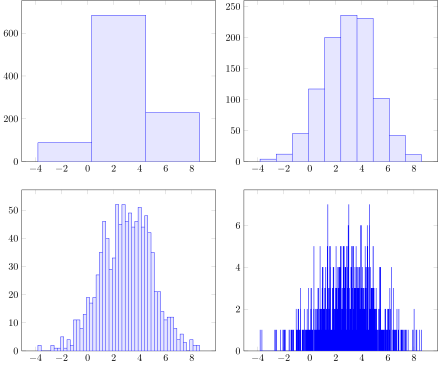

In [3]:
# define a normal distribution with mean 3 and standard deviation 2
dist = Normal(3,2)
# generate 1000 samples
d = rand(dist, 1000)
# try out histograms with a variety of different number of bins
bins = [3 10 50 1000]
g = GroupPlot(2,2)
for i = 1:length(bins)
    push!(g, Axis(Plots.Histogram(d, bins=bins[i]), ymin=0))
end
g

Of course, these plots are not of densities (they do not integrate to 1).

## Mixture Model

This example will focus on Gaussian mixture components, but the code can support components from other distributions.

In [4]:
type MixtureModel
    components
    weights    
end

In [5]:
function Distributions.pdf(d::MixtureModel, x)
    sum([d.weights[i] * pdf(d.components[i], x) for i = 1:length(d.components)])
end;

In [6]:
dist = MixtureModel([Normal(-3,1), Normal(4,2)], [0.8, 0.2])

MixtureModel([Distributions.Normal{Int64}(μ=-3, σ=1),Distributions.Normal{Int64}(μ=4, σ=2)],[0.8,0.2])

In [7]:
function Distributions.rand(d::MixtureModel, n)
    # create an array c holding random components (based on weights)
    c = wsample(1:length(d.components), d.weights, n)
    # randomly generate sample from appropriate component distribution
    [rand(d.components[c[i]]) for i = 1:n]
end;

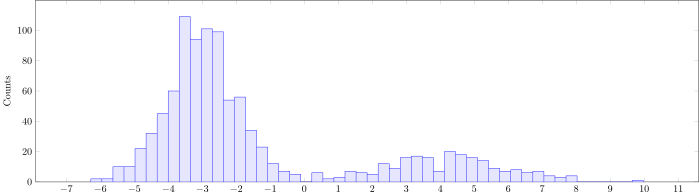

In [9]:
d = convert(Vector{Float64}, rand(dist, 1000))
a = Axis(Plots.Histogram(d, bins=50), ymin=0, ylabel="Counts", width="25cm", height="8cm")

Note the two bumps!

## Conditional Probability Distributions

### Binary

There are many types of conditional probability distributions. Here we'll focus on those with binary variables whose distribution can be specified using as table.

$$P(C \mid B, S)$$

In [16]:
target = :C
parents = [:B, :S]
parental_ncategories = [2, 2] # B and S can each be 1 or 2
distributions = [Bernoulli(0.8), # B = 1, S = 1     p(C == true | B = 1, S = 1) = 0.8
                 Bernoulli(0.2), # B = 2, S = 1
                 Bernoulli(0.3), # B = 1, S = 2
                 Bernoulli(0.5)] # B = 2, S = 2
cpd = CategoricalCPD(target, parents, parental_ncategories, distributions);

Let's make an assignment of variables to values.

In [17]:
a = Assignment(:B=>1, :S=>2)

Dict{Symbol,Any} with 2 entries:
  :S => 2
  :B => 1

In [18]:
pdf(cpd(a), true)

0.3

### Linear Gaussian

$$\mathcal{N}(\mu = a\cdot x + b, \sigma)$$

The constructor of CPDs.Normal takes a function mapping an assignment to
a tuple of parameters (i.e., mean and variance) for the Normal distribution

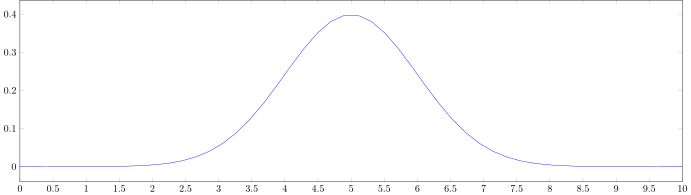

In [24]:
a = [5.0]; b = 0.0; σ = 1.0
cpd = LinearGaussianCPD(:y, [:x], a, b, σ)

PGFPlots.Axis(Plots.Linear(x->pdf(cpd(:x=>1.0), x), (0, 10)), xmin=0, xmax=10, width="25cm", height="8cm")

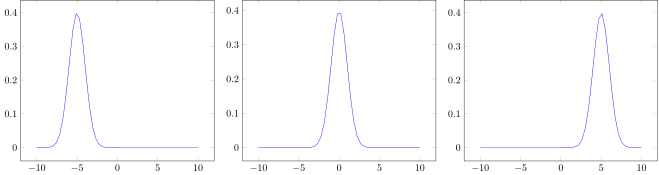

In [25]:
g = GroupPlot(3,1)
for x in -1:1
    push!(g, Plots.Linear(j->pdf(cpd(:x=>x), j), (-10, 10)))
end
g

## Bayesian Networks

A Bayesian network is a directed acyclic graph comprised of conditional probability distributions.

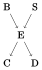

In [27]:
bn = DiscreteBayesNet()
push!(bn, DiscreteCPD(:B, [0.1,0.9]))
push!(bn, DiscreteCPD(:S, [0.5,0.5]))
push!(bn, rand_cpd(bn, 2, :E, [:B, :S]))
push!(bn, rand_cpd(bn, 2, :D, [:E]))
push!(bn, rand_cpd(bn, 2, :C, [:E]))

Let's compute the probability of an assignment using the chain rule.

In [28]:
a = Assignment(
    :B=>1,
    :S=>2,
    :E=>1,
    :D=>2,
    :C=>2
)

Dict{Symbol,Any} with 5 entries:
  :S => 2
  :C => 2
  :B => 1
  :D => 2
  :E => 1

Here are the conditional probabilities.

In [29]:
[pdf(get(bn, name), a) for name in names(bn)]

5-element Array{Any,1}:
 0.1     
 0.5     
 0.32119 
 0.557246
 0.53359 

In [30]:
prod([pdf(get(bn, name), a) for name in names(bn)])

0.004775154799316417

The library implements this for you:

In [31]:
pdf(bn, a)

0.004775154799316417

## TCAS Encounters

![TCAS](figures/TCAS_Volume.png)

# Week 3 Assignment - Encounter Plotting

Your task is to:

1.  Load example aircraft tracks from a file and plot them.
2.  Propose a statistical model for capturing features from the data.

Turn in your final Julia notebook file (.ipynb) on Coursework for part (1) and a document describing your proposed statistical model for part (2) to coursework.

### Aircraft Tracks

![Encounter](figures/encounter_plot.png)

An airspace encounter consists of two components - the initial conditions and the transitions over time.
One file is provided for each.

The initial conditions file, [`initial.txt`](initial.txt), contains a table with the following columns:

| Variable | Type | Description |
| -------- |:----:| ----------- |
| **id**       | Int  | trace id    |
| **A**      | Int  | index corresponding to the airspace class (i.e., B, C, D, or other) |
| **C1**    | Int   | category of aircraft 1 |
| **C2**    | Int   | category of aircraft 2 |

The transitions file, [`transition.txt`](transition.txt), contains a table with the following columns:

| Variable | Type | Description |
| -------- |:----:| ----------- |
| **id**                  | Int   | trace id, same as in `initial.txt`    |
| **t**                   | Int   | time in 1s intervals from 0 to 50    |
| **n1**                  | Int   | airplane 1 northing [ft/s] | **n2**                  | Int   | airplane 2 northing [ft/s]   |
| **e1**                  | Int   | airplane 1 easting [ft/s]  | **e2**                  | Int   | airplane 2 easting [ft/s]    |
| **h1**                  | Int   | airplane 1 altitude [ft]    | **h2**                  | Int   | airplane 2 altitude [ft]    |
| **v1**                  | Int   | airplane 1 horizontal speed [ft/s]    | **v1**                  | Int   | airplane 2 horizontal speed [ft/s]    |
| **ψ1**                  | Int   | airplane 1 heading [deg]    | **ψ2**                  | Int   | airplane 2 heading [deg]    |

Write a program to load these trajectories and plot them.

1.  Your algorithm must be implemented from scratch in Julia.
2.  Although you may discuss your algorithm with others, you must not share code.

Directions

* Implement `pull_encounter` to load a specific `Encounter` from initial and transition
* Modify `plot_encounter` to indicate the location of minimim separation

In [3]:
# Load initial.txt as a DataFrame
using DataFrames
initial = readtable(Pkg.dir("AA120Q", "data", "initial_small.txt"))

,id,A,C1,C2
1,1,4,2,2
2,2,4,2,2
3,3,2,2,2


In [4]:
# Load traces.txt as a DataFrame
traces = readtable(Pkg.dir("AA120Q", "data", "traces_small.txt"))
traces[1:3,:]

,id,t,n1,e1,h1,v1,ψ1,n2,e2,h2,v2,ψ2
1,1,0,-8663.356343901081,334.6189855606664,8273.006246536497,280.548,-13.715783000000005,2172.6419947992413,-4228.932261893066,1685.3174490867889,156.281,200.15960299999992
2,1,1,-8470.635911654446,381.65540917758483,8074.628853288174,280.548,-12.986118000000005,2025.9353555932234,-4175.072137739151,1685.3174490867889,154.82377,203.0110329999999
3,1,2,-8277.33211172748,426.23377933392,7876.25146003985,280.548,-12.256453000000006,1883.4309754667102,-4114.550229294595,1685.3174490867889,153.36654,205.8624629999999


`AircraftState` - a type which describes the aircraft state

In [5]:
immutable AircraftState
    n::Float64  # northing   [ft]
    e::Float64  # easting    [ft]
    h::Float64  # altitude   [ft]
    ψ::Float64  # heading    [deg] (angle CCW from north)
    v::Float64  # speed      [ft/s] (total speed in 3D)
    hd::Float64 # climb rate [ft/s] (vertical speed component)
end

`Encounter` - a type which describes an encounter

In [6]:
type Encounter
    A::Int  # aircraft type
    C1::Int # category of aircraft 1
    C2::Int # category of aircraft 2
    Δt::Float64 # constant timestep between frames [sec]
    trace1::Vector{AircraftState} # aircraft states for AC1, ordered in time
    trace2::Vector{AircraftState} # aircraft states for AC1, ordered in time

    function Encounter(
        A::Int,
        C1::Int,
        C2::Int,
        Δt::Float64,
        trace1::Vector{AircraftState},
        trace2::Vector{AircraftState},
        )

        retval = new()
        retval.A = A
        retval.C1 = C1
        retval.C2 = C2
        retval.Δt = Δt
        retval.trace1 = trace1
        retval.trace2 = trace2
        retval
    end
end

In [7]:
function pull_encounter(initial::DataFrame, traces::DataFrame, id::Int)

    # This function will prepare an "Encounter" data structure for plotting (see below),
    # by initializing the aircraft traces (trace1, trace2) into arrays of 51 elements (use the
    # Array() function in Julia to initialize the aircraft traces). 
    
    # Use a for loop to populate the aircraft states of the trace arrays, from the initial and
    # transitional data tables provided (initial.txt, traces.txt).
    # You must calculate "Δt" from the time difference in the trace data.
    
    ################
    # YOUR CODE HERE
    ################
    
    Encounter(initial[id, :A], initial[id, :C1], initial[id, :C2],
              Δt, trace1, trace2)
    
end

pull_encounter (generic function with 1 method)

In [9]:
using Plots
plotlyjs() # use the PlotlyJS backend

function plot_encounter(enc::Encounter)

    trace1, trace2 = enc.trace1, enc.trace2

    palette=[colorant"0x52E3F6", colorant"0x79ABFF"]
    t_arr = (collect(1:length(trace1)).-1) .* enc.Δt

    e1_arr = map(s->s.e,trace1)
    n1_arr = map(s->s.n,trace1)
    e2_arr = map(s->s.e,trace2)
    n2_arr = map(s->s.n,trace2)

    min_e1, max_e1 = extrema(e1_arr)
    min_n1, max_n1 = extrema(n1_arr)
    min_e2, max_e2 = extrema(e2_arr)
    min_n2, max_n2 = extrema(n2_arr)

    max_e = max(max_e1, max_e2)
    max_n = max(max_n1, max_n2)
    min_e = min(min_e1, min_e2)
    min_n = min(min_n1, min_n2)

    w = max(abs(max_e), abs(min_e), abs(max_n), abs(min_n)) + 500

    p1 = plot(Vector{Float64}[e1_arr, e2_arr],
              Vector{Float64}[n1_arr, n2_arr],
              xlabel="East (ft)", ylabel="North (ft)", palette=palette, linewidth=4, xlims=(-w,w), ylims=(-w,w))
    
    # initial positions
    scatter!(p1, Vector{Float64}[Float64[trace1[1].e], Float64[trace2[1].e]],
                 Vector{Float64}[Float64[trace1[1].n], Float64[trace2[1].n]])

    p2 = plot(Vector{Float64}[t_arr, t_arr],
              Vector{Float64}[map(s->s.h,trace1), map(s->s.h,trace2)],
              xlabel="Time (s)", ylabel="Altitude (ft)", leg=false, palette=palette, linewidth=4,
              annotations=(i,(trace1[i].h+trace2[i].h)/2, Plots.text(@sprintf("mid dist: %.0f ft", d))))
    
    ################
    # YOUR CODE HERE
    
    # compute the minimum 3D separation distance between aircraft
    # and the index at which it occurs
    minimum_distance = NaN
    index_at_min_dist = 0
    
    # plot!(p1, [trace1[i].e, trace2[i].e], [trace1[i].n, trace2[i].n], color=colorant"0xFF007F", linewidth=4)
    # plot!(p2, [(i-1)*enc.Δt,(i-1)*enc.Δt], [trace1[i].h, trace2[i].h], color=colorant"0xFF007F", linewidth=4)
    
    ################

    plot(p1, p2, size=(950,400))
end

plot_encounter (generic function with 1 method)

In [10]:
enc = pull_encounter(initial, traces, 1)
plot_encounter(enc)

LoadError: LoadError: UndefVarError: Δt not defined
while loading In[10], in expression starting on line 1

In [11]:
enc = pull_encounter(initial, traces, 2)
plot_encounter(enc)

LoadError: LoadError: UndefVarError: Δt not defined
while loading In[11], in expression starting on line 1

In [12]:
enc = pull_encounter(initial, traces, 3)
plot_encounter(enc)

LoadError: LoadError: UndefVarError: Δt not defined
while loading In[12], in expression starting on line 1

### Propose an Encounter Model

Now that you are familiar with the Probabilistic Models discussed in class (and described in section 2.1 of DMU), you will propose an encounter model. Your model should be designed such that you can sample from it and produce initial positions for each aircraft. Your model should also support propagating the aircraft forward - ie, describe how the encounter changes over time from the initial setup.

You must explain the reasoning behind your decision, how it captures the initial and transition distributions, and how it can be learned from large initial and transition data tables.